# Finding Winners in the Public Markets using Historical Financials p.2

Now that we have a dataset with the metrics/measurements, we can create scores based on Value, Quality, Growth, Margin Growth and Balance Sheet. I have removed companies in Biotechnology, Banks, and Insurance industries because their metrics and financials are very different from most companies. 

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import simfin as sf

#import datetime
from datetime import datetime, timedelta
from pandas.tseries.offsets import BDay

#display
pd.options.display.max_rows = 5000
pd.options.display.max_columns = 5000

import matplotlib.pyplot as plt
import matplotlib.lines as mlines

import warnings
warnings.filterwarnings('ignore')

In [2]:
%%time 
sf.set_data_dir('~/simfin_data/')
# sf.set_api_key(api_key='free')
sf.load_api_key(path='~/simfin_api_key.txt', default_key='free')
#Data for US
market = 'us'
# Daily Share-Prices.
df_prices = sf.load_shareprices(variant='daily', market=market, refresh_days = 1)

Dataset "us-shareprices-daily" on disk (0 days old).
- Loading from disk ... Done!
Wall time: 19.2 s


In [3]:
#import pickle
df = pd.read_pickle('dfpickle')
latest = pd.read_pickle('latestpickle')

#Business Services, Consumer Cyclical, Consumer Defensive, Industrials, Technology
# df = df[df.Sector.isin(['Business Services',np.nan, 'Consumer Cyclical', \
#                         'Consumer Defensive', 'Industrials', 'Technology','Other'])]

df= df[~df.Industry.isin(['Biotechnology','Banks','Insurance - Specialty',
                          'Insurance - Property & Casualty','Insurance','Insurance - Life'])]

train = df[['Ticker','Company Name', 'Report Date', 'publish_date', 'year', 'quarter',
    'Sector', 'Industry', 'mc', 'ev', 'ev_sales', 'ev_ebitda', 'ebitda_margin', 
    'gp_margin', 'np_margin', 'cfo_margin', 'fcf_margin','fat','cash_mc', 
    'fcf_yield','cfo_yield', 'bs_debt_ebitda','bs_ppe_apev','bs_current_ratio',
    'cf_invest_apr','lt_invest_apr','acq_divest_apr',
    'rev_growth_1', 'gp_growth_1', 'oi_growth_1', 'ni_growth_1', 'ebitda_growth_1',
    'cfo_growth_1', 'fcf_growth_1', 'ebitda_margrow_1','gp_margrow_1', 'np_margrow_1',
    'cfo_margrow_1', 'fcf_margrow_1','close_pct']]

test = latest[['Ticker','Company Name', 'Report Date', 'publish_date', 'year', 'quarter',
    'Sector', 'Industry', 'mc', 'ev', 'ev_sales', 'ev_ebitda', 'ebitda_margin',
    'cf_invest_apr','lt_invest_apr','acq_divest_apr',
    'gp_margin', 'np_margin', 'cfo_margin', 'fcf_margin','fat','cash_mc', 
    'fcf_yield','cfo_yield', 'bs_debt_ebitda','bs_ppe_apev','bs_current_ratio',
    'rev_growth_1','gp_growth_1', 'oi_growth_1', 'ni_growth_1', 'ebitda_growth_1',
    'cfo_growth_1', 'fcf_growth_1', 'ebitda_margrow_1','gp_margrow_1', 'np_margrow_1',
    'cfo_margrow_1', 'fcf_margrow_1','close_pct']]

train = train.replace([np.inf, -np.inf], np.nan)
test = test.replace([np.inf, -np.inf], np.nan)

train = train[(~train.close_pct.isnull())&(~train.ev.isnull())&(train.year != 2010)&(train.close_pct<2)
              &(~train.gp_margin.isnull())&(train.Ticker != 'SINO')&(~train.cfo_growth_1.isnull())&\
              (~train.oi_growth_1.isnull())& (~train.fcf_growth_1.isnull())&(~train.np_margrow_1.isnull())&\
              (~train.bs_current_ratio.isnull())]
              

In [4]:
train.isnull().sum()

Ticker                  0
Company Name            0
Report Date             0
publish_date            0
year                    0
quarter                 0
Sector               1356
Industry             1356
mc                      0
ev                      0
ev_sales                0
ev_ebitda               0
ebitda_margin           0
gp_margin               0
np_margin               0
cfo_margin              0
fcf_margin              0
fat                     0
cash_mc                 0
fcf_yield               0
cfo_yield               0
bs_debt_ebitda       3323
bs_ppe_apev             0
bs_current_ratio        0
cf_invest_apr         132
lt_invest_apr       31354
acq_divest_apr      29826
rev_growth_1            0
gp_growth_1             0
oi_growth_1             0
ni_growth_1             0
ebitda_growth_1         0
cfo_growth_1            0
fcf_growth_1            0
ebitda_margrow_1        0
gp_margrow_1            0
np_margrow_1            0
cfo_margrow_1           0
fcf_margrow_

In [5]:
train.shape

(44840, 40)

In [6]:
df.columns

Index(['Ticker', 'Report Date', 'id', 'year', 'quarter', 'publish_date',
       'revenue', 'cogs', 'gp', 'oi', 'ni', 'shares', 'rnd', 'ebitda_oi',
       'ebitda_ni', 'ebitda', 'ebitda_margin', 'fat', 'gp_margin', 'np_margin',
       'cash', 'st_debt', 'lt_debt', 'inventory', 'ppe', 'receivables',
       'payables', 'current_assets', 'current_liabilities', 'cfo', 'capex',
       'lt_invest', 'acq_divest', 'cfi', 'dividends_paid', 'buyback', 'fcf',
       'cfo_margin', 'fcf_margin', 'Date', 'Close', 'Adj. Close', 'close_pct',
       'adj_close_pct', 'SimFinId', 'Company Name', 'IndustryId', 'Sector',
       'Industry', 'mc', 'cash_mc', 'fcf_yield', 'cfo_yield', 'se_yield', 'ev',
       'ev_sales', 'ev_ebitda', 'bs_ppe_apev', 'bs_current_ratio',
       'bs_debt_ebitda', 'rev_growth_1', 'gp_growth_1', 'oi_growth_1',
       'ni_growth_1', 'ebitda_growth_1', 'cfo_growth_1', 'fcf_growth_1',
       'ebitda_margrow_1', 'fat_growth_1', 'gp_margrow_1', 'np_margrow_1',
       'cfo_margrow_1', 'fc

# Functions

In [7]:
def newline(p1, p2):
    ax = plt.gca()
    xmin, xmax = ax.get_xbound()

    if(p2[0] == p1[0]):
        xmin = xmax = p1[0]
        ymin, ymax = ax.get_ybound()
    else:
        ymax = p1[1]+(p2[1]-p1[1])/(p2[0]-p1[0])*(xmax-p1[0])
        ymin = p1[1]+(p2[1]-p1[1])/(p2[0]-p1[0])*(xmin-p1[0])

    l = mlines.Line2D([xmin,xmax], [ymin,ymax])
    ax.add_line(l)
    return l

### Creating the following functions: analyze(), trainset(), testset(), manual(), check_score()

### Analyze(x)

Input a Industry as x. For example, analyze('Application Software'). Unique industries are generated below.

The function will split the metrics by deciles relative to its peers. Top of the decile receives a score of 10, lowest of the decile receives score of 1.

Then I group those scores by Value, Quality, Growth, Margin Growth, and Balance Sheet strength. I assign weights to these categories based on their correlation to stock price performance in the past for each industry.

In [8]:
df['Industry'].unique()

array(['Medical Diagnostics & Research', 'Metals & Mining',
       'Health Care Providers', 'Airlines', 'Asset Management',
       'Consulting & Outsourcing', 'Semiconductors',
       'Industrial Products', 'Retail - Apparel & Specialty',
       'Computer Hardware', 'Transportation & Logistics',
       'Aerospace & Defense', 'Drug Manufacturers',
       'Medical Distribution', 'Education', 'Autos', 'Business Services',
       'Medical Devices', nan, 'Engineering & Construction',
       'Communication Equipment', 'Communication Services', 'Consulting',
       'Truck Manufacturing', 'Application Software',
       'Consumer Packaged Goods', 'Credit Services',
       'Oil & Gas - Integrated', 'Utilities - Regulated',
       'Packaging & Containers', 'Building Materials',
       'Farm & Construction Machinery', 'REITs', 'Employment Services',
       'Industrial Distribution', 'Brokers & Exchanges',
       'Medical Instruments & Equipment', 'Steel', 'Chemicals',
       'Oil & Gas - Refining 

In [9]:
#Using different weights for different categories
#input industry in x
def analyze(x):
    print(x)
    data = train[train.Industry.isin([x])].reset_index(drop = True)
    data_test = test[test.Industry.isin([x])].reset_index(drop = True)

    #create score columns
    data['ev_sales_score'] = pd.qcut(data.ev_sales, 10 ,labels = False, duplicates = 'drop').map(lambda x:((10-x)))
    data['ev_ebitda_score'] = np.where(data.ev_ebitda<0,0,pd.qcut(data.ev_ebitda, 10 ,labels = False, \
                                                                  duplicates = 'drop').map(lambda x:((10-x))))
    
    data['bs_debt_ebitda_score'] = pd.qcut(data.bs_debt_ebitda, 10, labels = False, duplicates = 'drop').map(lambda x: (10-x)) 
    
    for x in data.columns[data.columns.isin(['ebitda_margin', 'gp_margin', 'np_margin', 'cfo_margin', 'fcf_margin',
   'fat', 'cash_mc', 'fcf_yield', 'cfo_yield','bs_ppe_apev', 'bs_current_ratio', 
    'cf_invest_apr','lt_invest_apr','acq_divest_apr','rev_growth_1',
   'gp_growth_1', 'oi_growth_1', 'ni_growth_1', 'ebitda_growth_1',
   'cfo_growth_1', 'fcf_growth_1', 'ebitda_margrow_1', 'gp_margrow_1',
   'np_margrow_1', 'cfo_margrow_1', 'fcf_margrow_1'])]:
        data[''.join([x,'_score'])] = pd.qcut(data[x], 10, labels = False, duplicates = 'drop')

    #calc correlations and get highly correlated features
    correl = pd.DataFrame(data.corr()['close_pct']).sort_values(by = 'close_pct').\
                                                    reset_index().rename(columns = {'index':'features'})

    correl = correl[(correl.features.str.contains('score'))&(correl.close_pct > 0.03)]
    features = pd.Series(correl.features.tolist())
     
    print(features)
    
    data['score'] = np.mean(data[features], axis =1)
    data['round_score'] = round(data.score)

    #Value features and weights
    value_features = features[features.str.contains('yield|ev_sales|ev_ebitda')].to_list()
    quality_features = features[features.str.contains('margin|fat')].to_list()
    growth_features = features[features.str.contains('growth')].to_list()
    margrow_features = features[features.str.contains('margrow')].to_list()
    bs_features = features[features.str.contains('bs|cash|vest')].to_list()

    data['value_score'] = np.nanmean(data[value_features], axis = 1)
    data['quality_score'] = np.nanmean(data[quality_features], axis = 1)
    data['growth_score'] = np.nanmean(data[growth_features], axis = 1)
    data['margrow_score'] = np.nanmean(data[margrow_features], axis = 1)
    data['bs_score'] = np.nanmean(data[bs_features], axis = 1)

    data['round_value_score'] = round(data.value_score)
    data['round_quality_score'] = round(data.quality_score)
    data['round_growth_score'] = round(data.growth_score)
    data['round_margrow_score'] = round(data.margrow_score)
    data['round_bs_score'] = round(data.bs_score)

    weights = pd.DataFrame(data.corr()['close_pct']).sort_values(by = 'close_pct').\
                                                reset_index().rename(columns = {'index':'features'})

    weights = weights[(weights.features.str.contains('round_.+_score'))]
    weights.close_pct = weights.close_pct/weights.close_pct.sum()

    value_weight = float(weights.loc[weights.features == 'round_value_score','close_pct'])
    growth_weight = float(weights.loc[weights.features == 'round_growth_score','close_pct'])
    quality_weight = float(weights.loc[weights.features == 'round_quality_score','close_pct'])
    margin_growth_weight = float(weights.loc[weights.features == 'round_margrow_score','close_pct'])
    bs_weight = float(weights.loc[weights.features == 'round_bs_score','close_pct'])
    
    print('Value Weight: ', value_weight)
    print('Growth Weight: ', growth_weight)
    print('Quality Weight: ', quality_weight)
    print('Margin Growth Weight: ', margin_growth_weight)
    print('Balance Sheet Weight: ', bs_weight)
    print('\n')

    #create weighted scores based on correlation
    data['score'] = np.nansum([(data.value_score * value_weight), (data.growth_score * growth_weight),\
                    (data.quality_score * quality_weight), (data.margrow_score * margin_growth_weight),
                              (data.bs_score * bs_weight)], axis = 0)

    data['round_score'] = round(data.score)

    data_dict = {}

    features = ['ev_sales', 'ev_ebitda',
       'ebitda_margin', 'gp_margin', 'np_margin', 'cfo_margin', 'fcf_margin',
       'fat', 'cash_mc', 'fcf_yield', 'cfo_yield', 'bs_debt_ebitda',
       'bs_ppe_apev', 'bs_current_ratio', 'cf_invest_apr','lt_invest_apr','acq_divest_apr',
       'rev_growth_1', 'gp_growth_1', 'oi_growth_1', 'ni_growth_1', 'ebitda_growth_1',
       'cfo_growth_1', 'fcf_growth_1', 'ebitda_margrow_1', 'gp_margrow_1',
       'np_margrow_1', 'cfo_margrow_1', 'fcf_margrow_1']

    for x in features:
        data_dict.setdefault(x, [])
        data_dict[x].append(pd.qcut(data[x], 10, retbins = True, duplicates = 'drop')[1])
        
    for x in data_dict.values():
        x[0][0] = -np.inf
        x[0][len(x[0])-1] = np.inf
    
    print(data_dict)
    print('\n')
    
    #OVERALL SCORES CHART
    print('Overall Scores')
    print(data.groupby(['round_score']).agg({'Ticker':'count','close_pct':'mean'}))
    data.groupby(['round_score'])['close_pct'].mean().plot.bar()
    plt.show()
    
    score = data.groupby(['year','round_score'])['close_pct'].mean()

    num = (score.reset_index().year.unique().__len__())
    
    for x in range(num):
        a = data.year.unique().min()
        print(data.Industry.unique())
        print(a + x)
        print(data[data.year == (a+x)].groupby('round_score').agg({'Ticker':'count','close_pct':'mean'}))
        score.unstack('round_score').iloc[x].plot.bar()
        p1 = [1,np.mean(score.unstack('round_score').iloc[x])]
        p2 = [15,np.mean(score.unstack('round_score').iloc[x])]
        newline(p1,p2)
        plt.show()

    data_test['ev_sales_score'] = pd.cut(data_test['ev_sales'], bins = data_dict['ev_sales'][0], labels = False, duplicates = 'drop').\
                                        map(lambda x: (10-x))
    data_test['ev_ebitda_score'] = np.where(data_test['ev_ebitda']<0,0,pd.cut(data_test['ev_ebitda'], bins = data_dict['ev_ebitda'][0], labels = False, duplicates = 'drop').\
                                            map(lambda x: (10-x)))
    
    data_test['bs_debt_ebitda_score'] = pd.cut(data_test.bs_debt_ebitda, bins = data_dict['bs_debt_ebitda'][0],\
                                               labels = False, duplicates = 'drop').map(lambda x: (10-x))

    features = ['ebitda_margin', 'gp_margin', 'np_margin', 'cfo_margin', 'fcf_margin',
   'fat', 'cash_mc', 'fcf_yield', 'cfo_yield','bs_ppe_apev', 'bs_current_ratio', 
   'cf_invest_apr','lt_invest_apr','acq_divest_apr','rev_growth_1',
   'gp_growth_1', 'oi_growth_1', 'ni_growth_1', 'ebitda_growth_1',
   'cfo_growth_1', 'fcf_growth_1', 'ebitda_margrow_1', 'gp_margrow_1',
   'np_margrow_1', 'cfo_margrow_1', 'fcf_margrow_1']

    for x in features:
        data_test[''.join([x,'_score'])] = pd.cut(data_test[x], bins = data_dict[x][0], labels = False, duplicates = 'drop')

    data_test['value_score'] = np.nanmean(data_test[value_features], axis = 1)
    data_test['quality_score'] = np.nanmean(data_test[quality_features], axis = 1)
    data_test['growth_score'] = np.nanmean(data_test[growth_features], axis = 1)
    data_test['margrow_score'] = np.nanmean(data_test[margrow_features], axis = 1)
    data_test['bs_score'] = np.nanmean(data_test[bs_features], axis = 1)

    data_test['round_value_score'] = round(data_test.value_score)
    data_test['round_quality_score'] = round(data_test.quality_score)
    data_test['round_growth_score'] = round(data_test.growth_score)
    data_test['round_margrow_score'] = round(data_test.margrow_score)
    data_test['round_bs_score'] = round(data_test.bs_score)

    data_test['score'] = np.nansum([(data_test.value_score * value_weight), (data_test.growth_score * growth_weight),\
                        (data_test.quality_score * quality_weight), (data_test.margrow_score * margin_growth_weight),\
                                   (data_test.bs_score * bs_weight)], axis = 0)

    data_test['round_score'] = round(data_test.score)
    

    print('TEST DATASET RESULTS')
    print(data_test.Industry.unique())
    data_test.groupby('round_score')['close_pct'].mean().plot.bar()
    plt.show()

### Trainset and Testset

Testset is latest dataset as of the last quarter for that company. 
Trainset is all data prior to the last quarter for that company. 
We create deciles using the trainset to estimate scores for the testset.

Trainset(x). Input industry for x.
Testset(x). Input industry for x.

Returns a dataframe of all companies in that industry with their decile scores.

In [10]:
#Return Train set
def trainset(x):
#     print(x)
    data = train[train.Industry.isin([x])].reset_index(drop = True)

    #create score columns
    data['ev_sales_score'] = pd.qcut(data.ev_sales, 10 ,labels = False, duplicates = 'drop').map(lambda x:((10-x)))
    data['ev_ebitda_score'] = np.where(data.ev_ebitda <0,0,pd.qcut(data.ev_ebitda, 10 ,labels = False,\
                                                                   duplicates = 'drop').map(lambda x:((10-x))))
    
    data['bs_debt_ebitda_score'] = pd.qcut(data.bs_debt_ebitda, 10, labels = False, duplicates = 'drop').map(lambda x: (10-x))
    
    for x in data.columns[data.columns.isin(['ebitda_margin', 'gp_margin', 'np_margin', 'cfo_margin', 'fcf_margin',
   'fat', 'cash_mc', 'fcf_yield', 'cfo_yield','bs_ppe_apev', 'bs_current_ratio',
   'cf_invest_apr','lt_invest_apr','acq_divest_apr','rev_growth_1',
   'gp_growth_1', 'oi_growth_1', 'ni_growth_1', 'ebitda_growth_1',
   'cfo_growth_1', 'fcf_growth_1', 'ebitda_margrow_1', 'gp_margrow_1',
   'np_margrow_1', 'cfo_margrow_1', 'fcf_margrow_1'])]:
        data[''.join([x,'_score'])] = pd.qcut(data[x], 10, labels = False, duplicates = 'drop' )

    #calc correlations and get highly correlated features
    correl = pd.DataFrame(data.corr()['close_pct']).sort_values(by = 'close_pct').\
                                                    reset_index().rename(columns = {'index':'features'})

    correl = correl[(correl.features.str.contains('score'))&(correl.close_pct > 0.03)]
    features = pd.Series(correl.features.tolist())
     
#     print(features)
    
    #Value features and weights
    value_features = features[features.str.contains('yield|ev_sales|ev_ebitda')].to_list()
    quality_features = features[features.str.contains('margin|fat')].to_list()
    growth_features = features[features.str.contains('growth')].to_list()
    margrow_features = features[features.str.contains('margrow')].to_list()
    bs_features = features[features.str.contains('bs|cash|vest')].to_list()

    data['value_score'] = np.nanmean(data[value_features], axis = 1)
    data['quality_score'] = np.nanmean(data[quality_features], axis = 1)
    data['growth_score'] = np.nanmean(data[growth_features], axis = 1)
    data['margrow_score'] = np.nanmean(data[margrow_features], axis = 1)
    data['bs_score'] = np.nanmean(data[bs_features], axis = 1)

    data['round_value_score'] = round(data.value_score)
    data['round_quality_score'] = round(data.quality_score)
    data['round_growth_score'] = round(data.growth_score)
    data['round_margrow_score'] = round(data.margrow_score)
    data['round_bs_score'] = round(data.bs_score)

    weights = pd.DataFrame(data.corr()['close_pct']).sort_values(by = 'close_pct').\
                                                reset_index().rename(columns = {'index':'features'})

    weights = weights[(weights.features.str.contains('round_.+_score'))]
    weights.close_pct = weights.close_pct/weights.close_pct.sum()

    value_weight = float(weights.loc[weights.features == 'round_value_score','close_pct'])
    growth_weight = float(weights.loc[weights.features == 'round_growth_score','close_pct'])
    quality_weight = float(weights.loc[weights.features == 'round_quality_score','close_pct'])
    margin_growth_weight = float(weights.loc[weights.features == 'round_margrow_score','close_pct'])
    bs_weight = float(weights.loc[weights.features == 'round_bs_score','close_pct'])
    
#     print('Value Weight: ', value_weight)
#     print('Growth Weight: ', growth_weight)
#     print('Quality Weight: ', quality_weight)
#     print('Margin Growth Weight: ', margin_growth_weight)
#     print('Balance Sheet Weight: ', bs_weight)
#     print('\n')

    #create weighted scores based on correlation
    data['score'] = np.nansum([(data.value_score * value_weight), (data.growth_score * growth_weight),\
                    (data.quality_score * quality_weight), (data.margrow_score * margin_growth_weight),
                              (data.bs_score * bs_weight)], axis = 0)

    data['round_score'] = round(data.score)
    
    return data.sort_values('score', ascending = False)

In [11]:
#returns scores for your test set by Industry. 
#input industry in x
def testset(x):
    data = train[train.Industry.isin([x])].reset_index(drop = True)
    data_test = test[test.Industry.isin([x])].reset_index(drop = True)

    #create score columns
    data['ev_sales_score'] = pd.qcut(data.ev_sales, 10 ,labels = False, duplicates = 'drop').map(lambda x:((10-x)))
    data['ev_ebitda_score'] = np.where(data.ev_ebitda<0,0,pd.qcut(data.ev_ebitda, 10 ,labels = False, \
                                                                  duplicates = 'drop').map(lambda x:((10-x))))
    
    data['bs_debt_ebitda_score'] = pd.qcut(data.bs_debt_ebitda, 10, labels = False, duplicates = 'drop').map(lambda x: (10-x))
        
    for x in data.columns[data.columns.isin(['ebitda_margin', 'gp_margin', 'np_margin', 'cfo_margin', 'fcf_margin',
   'fat', 'cash_mc', 'fcf_yield', 'cfo_yield','bs_ppe_apev', 'bs_current_ratio',
   'cf_invest_apr','lt_invest_apr','acq_divest_apr','rev_growth_1',
   'gp_growth_1', 'oi_growth_1', 'ni_growth_1', 'ebitda_growth_1',
   'cfo_growth_1', 'fcf_growth_1', 'ebitda_margrow_1', 'gp_margrow_1',
   'np_margrow_1', 'cfo_margrow_1', 'fcf_margrow_1'])]:
        data[''.join([x,'_score'])] = pd.qcut(data[x], 10, labels = False, duplicates = 'drop')

    #calc correlations and get highly correlated features
    correl = pd.DataFrame(data.corr()['close_pct']).sort_values(by = 'close_pct').\
                                                    reset_index().rename(columns = {'index':'features'})

    correl = correl[(correl.features.str.contains('score'))&(correl.close_pct > 0.03)]
    features = pd.Series(correl.features.tolist())
    
    data['score'] = np.mean(data[features], axis =1)
    data['round_score'] = round(data.score)

    #Value features and weights
    value_features = features[features.str.contains('yield|ev_sales|ev_ebitda')].to_list()
    quality_features = features[features.str.contains('margin|fat')].to_list()
    growth_features = features[features.str.contains('growth')].to_list()
    margrow_features = features[features.str.contains('margrow')].to_list()
    bs_features = features[features.str.contains('bs|cash|vest')].to_list()

    data['value_score'] = np.nanmean(data[value_features], axis = 1)
    data['quality_score'] = np.nanmean(data[quality_features], axis = 1)
    data['growth_score'] = np.nanmean(data[growth_features], axis = 1)
    data['margrow_score'] = np.nanmean(data[margrow_features], axis = 1)
    data['bs_score'] = np.nanmean(data[bs_features], axis = 1)

    data['round_value_score'] = round(data.value_score)
    data['round_quality_score'] = round(data.quality_score)
    data['round_growth_score'] = round(data.growth_score)
    data['round_margrow_score'] = round(data.margrow_score)
    data['round_bs_score'] = round(data.bs_score)

    weights = pd.DataFrame(data.corr()['close_pct']).sort_values(by = 'close_pct').\
                                                reset_index().rename(columns = {'index':'features'})

    weights = weights[(weights.features.str.contains('round_.+_score'))]
    weights.close_pct = weights.close_pct/weights.close_pct.sum()

    value_weight = float(weights.loc[weights.features == 'round_value_score','close_pct'])
    growth_weight = float(weights.loc[weights.features == 'round_growth_score','close_pct'])
    quality_weight = float(weights.loc[weights.features == 'round_quality_score','close_pct'])
    margin_growth_weight = float(weights.loc[weights.features == 'round_margrow_score','close_pct'])
    bs_weight = float(weights.loc[weights.features == 'round_bs_score','close_pct'])
    
        #create weighted scores based on correlation
    data['score'] = np.nansum([(data.value_score * value_weight), (data.growth_score * growth_weight),\
                    (data.quality_score * quality_weight), (data.margrow_score * margin_growth_weight),
                              (data.bs_score * bs_weight)], axis = 0)

    data['round_score'] = round(data.score)

    data_dict = {}

    features = ['ev_sales', 'ev_ebitda',
       'ebitda_margin', 'gp_margin', 'np_margin', 'cfo_margin', 'fcf_margin',
       'fat', 'cash_mc', 'fcf_yield', 'cfo_yield', 'bs_debt_ebitda',
       'bs_ppe_apev', 'bs_current_ratio',  'cf_invest_apr','lt_invest_apr','acq_divest_apr','rev_growth_1',
       'gp_growth_1', 'oi_growth_1', 'ni_growth_1', 'ebitda_growth_1',
       'cfo_growth_1', 'fcf_growth_1', 'ebitda_margrow_1', 'gp_margrow_1',
       'np_margrow_1', 'cfo_margrow_1', 'fcf_margrow_1']

    for x in features:
        data_dict.setdefault(x, [])
        data_dict[x].append(pd.qcut(data[x], 10, retbins = True, duplicates = 'drop')[1])
        
    for x in data_dict.values():
        x[0][0] = -np.inf
        x[0][len(x[0])-1] = np.inf
    
    data_test['ev_sales_score'] = pd.cut(data_test['ev_sales'], bins = data_dict['ev_sales'][0], labels = False, duplicates = 'drop').\
                                        map(lambda x: (10-x))
    data_test['ev_ebitda_score'] = np.where(data_test['ev_ebitda']<0,0,pd.cut(data_test['ev_ebitda'], bins = data_dict['ev_ebitda'][0], labels = False, duplicates = 'drop').\
                                            map(lambda x: (10-x)))
    
    data_test['bs_debt_ebitda_score'] = pd.cut(data_test.bs_debt_ebitda, bins = data_dict['bs_debt_ebitda'][0],\
                                               labels = False, duplicates = 'drop').map(lambda x: (10-x))
    
    features = ['ebitda_margin', 'gp_margin', 'np_margin', 'cfo_margin', 'fcf_margin',
   'fat', 'cash_mc', 'fcf_yield', 'cfo_yield','bs_ppe_apev', 'bs_current_ratio', 
   'cf_invest_apr','lt_invest_apr','acq_divest_apr', 'rev_growth_1',
   'gp_growth_1', 'oi_growth_1', 'ni_growth_1', 'ebitda_growth_1',
   'cfo_growth_1', 'fcf_growth_1', 'ebitda_margrow_1', 'gp_margrow_1',
   'np_margrow_1', 'cfo_margrow_1', 'fcf_margrow_1']

    for x in features:
        data_test[''.join([x,'_score'])] = pd.cut(data_test[x], bins = data_dict[x][0], labels = False, duplicates = 'drop')

    data_test['value_score'] = np.nanmean(data_test[value_features], axis = 1)
    data_test['quality_score'] = np.nanmean(data_test[quality_features], axis = 1)
    data_test['growth_score'] = np.nanmean(data_test[growth_features], axis = 1)
    data_test['margrow_score'] = np.nanmean(data_test[margrow_features], axis = 1)
    data_test['bs_score'] = np.nanmean(data_test[bs_features], axis = 1)

    data_test['round_value_score'] = round(data_test.value_score)
    data_test['round_quality_score'] = round(data_test.quality_score)
    data_test['round_growth_score'] = round(data_test.growth_score)
    data_test['round_margrow_score'] = round(data_test.margrow_score)
    data_test['round_bs_score'] = round(data_test.bs_score)

    data_test['score'] = np.nansum([(data_test.value_score * value_weight), (data_test.growth_score * growth_weight),\
                        (data_test.quality_score * quality_weight), (data_test.margrow_score * margin_growth_weight),\
                                   (data_test.bs_score * bs_weight)], axis = 0)

    data_test['round_score'] = round(data_test.score)

    return data_test.sort_values('score', ascending = False)

Previously we have been inputting different Industries for functions, analyze(), trainset(), testset().
The following functions fulltest and fulltrain, concatenate all industries to create a full dataset.

In [12]:
def fulltest(L):
    empty_df = pd.DataFrame()
    for x in L:
        empty_df = pd.concat([empty_df,testset(x)], axis = 0)
    return empty_df.sort_values('score', ascending = False).reset_index(drop = True)

def fulltrain(L):
    empty_df = pd.DataFrame()
    for x in L:
        empty_df = pd.concat([empty_df,trainset(x)], axis = 0)
    return empty_df.sort_values('score', ascending = False).reset_index(drop = True)

### check_score(T)
Input Ticker for T. 
e.g. check_score('AAPL')

This will generate which metrics have the highest correlation to stock price performance for that industry and how company 'T' measures up to its peers. It will show the weighted average score and how the scores were weighted. 

In [13]:
def check_score(T):
    industry = train[train.Ticker == T].Industry.unique()[0]
    data = train[train.Industry.isin([industry])].reset_index(drop = True)
    
    print(T)
    print(train.loc[train.Ticker == T,'Company Name'].unique()[0])
    print(industry)
    
    print('Price: ',latest.loc[latest.Ticker == T,'latest_close'].squeeze())

    #create score columns
    data['ev_sales_score'] = pd.qcut(data.ev_sales, 10 ,labels = False, duplicates = 'drop').map(lambda x:((10-x)))
    data['ev_ebitda_score'] = np.where(data.ev_ebitda<0,0,pd.qcut(data.ev_ebitda, 10 ,labels = False, \
                                                                  duplicates = 'drop').map(lambda x:((10-x))))
    
    data['bs_debt_ebitda_score'] = pd.qcut(data.bs_debt_ebitda, 10, labels = False, duplicates = 'drop').map(lambda x: (10-x))
     
    for x in data.columns[data.columns.isin(['ebitda_margin', 'gp_margin', 'np_margin', 'cfo_margin', 'fcf_margin',
   'fat', 'cash_mc', 'fcf_yield', 'cfo_yield','bs_ppe_apev', 'bs_current_ratio', 
   'cf_invest_apr','lt_invest_apr','acq_divest_apr','rev_growth_1',
   'gp_growth_1', 'oi_growth_1', 'ni_growth_1', 'ebitda_growth_1',
   'cfo_growth_1', 'fcf_growth_1', 'ebitda_margrow_1', 'gp_margrow_1',
   'np_margrow_1', 'cfo_margrow_1', 'fcf_margrow_1'])]:
        data[''.join([x,'_score'])] = pd.qcut(data[x], 10, labels = False, duplicates = 'drop')

    #calc correlations and get highly correlated features
    correl = pd.DataFrame(data.corr()['close_pct']).sort_values(by = 'close_pct').\
                                                    reset_index().rename(columns = {'index':'features'})

    correl = correl[(correl.features.str.contains('score'))&(correl.close_pct > 0.03)]
    features = pd.Series(correl.features.tolist())
     
    print(features)
    
    data['score'] = np.mean(data[features], axis =1)
    data['round_score'] = round(data.score)

    #Value features and weights
    value_features = features[features.str.contains('yield|ev_sales|ev_ebitda')].to_list()
    quality_features = features[features.str.contains('margin|fat')].to_list()
    growth_features = features[features.str.contains('growth')].to_list()
    margrow_features = features[features.str.contains('margrow')].to_list()
    bs_features = features[features.str.contains('bs|cash|vest')].to_list()

    data['value_score'] = np.nanmean(data[value_features], axis = 1)
    data['quality_score'] = np.nanmean(data[quality_features], axis = 1)
    data['growth_score'] = np.nanmean(data[growth_features], axis = 1)
    data['margrow_score'] = np.nanmean(data[margrow_features], axis = 1)
    data['bs_score'] = np.nanmean(data[bs_features], axis = 1)

    data['round_value_score'] = round(data.value_score)
    data['round_quality_score'] = round(data.quality_score)
    data['round_growth_score'] = round(data.growth_score)
    data['round_margrow_score'] = round(data.margrow_score)
    data['round_bs_score'] = round(data.bs_score)

    weights = pd.DataFrame(data.corr()['close_pct']).sort_values(by = 'close_pct').\
                                                reset_index().rename(columns = {'index':'features'})

    weights = weights[(weights.features.str.contains('round_.+_score'))]
    weights.close_pct = weights.close_pct/weights.close_pct.sum()

    value_weight = float(weights.loc[weights.features == 'round_value_score','close_pct'])
    growth_weight = float(weights.loc[weights.features == 'round_growth_score','close_pct'])
    quality_weight = float(weights.loc[weights.features == 'round_quality_score','close_pct'])
    margin_growth_weight = float(weights.loc[weights.features == 'round_margrow_score','close_pct'])
    bs_weight = float(weights.loc[weights.features == 'round_bs_score','close_pct'])
    
    print('Value Features:', value_features)
    print('Quality Features:', quality_features)
    print('Growth Features:', growth_features)
    print('Margin Growth Features:', margrow_features)
    print('Balance Sheet Features:', bs_features)
    print('\n')
    print('Value Weight: ', value_weight)
    print('Growth Weight: ', growth_weight)
    print('Quality Weight: ', quality_weight)
    print('Margin Growth Weight: ', margin_growth_weight)
    print('Balance Sheet Weight: ', bs_weight)
    print('\n')
        
    a = data.describe()[features.map(lambda x: x.replace('_score','')).tolist()].iloc[1:7]
    
    #create weighted scores based on correlation
    data_test = test[test.Industry.isin([industry])].reset_index(drop = True)

    data_dict = {}

    feature_one = ['ev_sales', 'ev_ebitda',
       'ebitda_margin', 'gp_margin', 'np_margin', 'cfo_margin', 'fcf_margin',
       'fat', 'cash_mc', 'fcf_yield', 'cfo_yield', 'bs_debt_ebitda', 'bs_ppe_apev', 
       'bs_current_ratio',  'cf_invest_apr','lt_invest_apr','acq_divest_apr','rev_growth_1',
       'gp_growth_1', 'oi_growth_1', 'ni_growth_1', 'ebitda_growth_1',
       'cfo_growth_1', 'fcf_growth_1', 'ebitda_margrow_1', 'gp_margrow_1',
       'np_margrow_1', 'cfo_margrow_1', 'fcf_margrow_1']

    for x in feature_one:
        data_dict.setdefault(x, [])
        data_dict[x].append(pd.qcut(data[x], 10, retbins = True,duplicates = 'drop')[1])

    for x in data_dict.values():
        x[0][0] = -np.inf
        x[0][len(x[0])-1] = np.inf


    data_test['ev_sales_score'] = pd.cut(data_test['ev_sales'], bins = data_dict['ev_sales'][0], labels = False, duplicates = 'drop').\
                                        map(lambda x: (10-x))
    data_test['ev_ebitda_score'] = np.where(data_test['ev_ebitda']<0,0,pd.cut(data_test['ev_ebitda'], bins = data_dict['ev_ebitda'][0], labels = False, duplicates = 'drop').\
                                            map(lambda x: (10-x)))
    
    data_test['bs_debt_ebitda_score'] = pd.cut(data_test.bs_debt_ebitda, bins = data_dict['bs_debt_ebitda'][0],\
                                               labels = False, duplicates = 'drop').map(lambda x: (10-x))
    
    feature_two = ['ebitda_margin', 'gp_margin', 'np_margin', 'cfo_margin', 'fcf_margin',
   'fat', 'cash_mc', 'fcf_yield', 'cfo_yield','bs_ppe_apev', 'bs_current_ratio', 
    'cf_invest_apr','lt_invest_apr','acq_divest_apr','rev_growth_1',
   'gp_growth_1', 'oi_growth_1', 'ni_growth_1', 'ebitda_growth_1',
   'cfo_growth_1', 'fcf_growth_1', 'ebitda_margrow_1', 'gp_margrow_1',
   'np_margrow_1', 'cfo_margrow_1', 'fcf_margrow_1']

    for x in feature_two:
        data_test[''.join([x,'_score'])] = pd.cut(data_test[x], bins = data_dict[x][0], labels = False, duplicates = 'drop')

    data_test['value_score'] = np.nanmean(data_test[value_features], axis = 1)
    data_test['quality_score'] = np.nanmean(data_test[quality_features], axis = 1)
    data_test['growth_score'] = np.nanmean(data_test[growth_features], axis = 1)
    data_test['margrow_score'] = np.nanmean(data_test[margrow_features], axis = 1)
    data_test['bs_score'] = np.nanmean(data_test[bs_features], axis = 1)

    data_test['round_value_score'] = round(data_test.value_score)
    data_test['round_quality_score'] = round(data_test.quality_score)
    data_test['round_growth_score'] = round(data_test.growth_score)
    data_test['round_margrow_score'] = round(data_test.margrow_score)
    data_test['round_bs_score'] = round(data_test.bs_score)

    data_test['score'] = np.nansum([(data_test.value_score * value_weight), (data_test.growth_score * growth_weight),\
                        (data_test.quality_score * quality_weight), (data_test.margrow_score * margin_growth_weight),\
                                   (data_test.bs_score * bs_weight)], axis = 0)

    data_test['round_score'] = round(data_test.score)
    
    print('Value Score:', data_test.loc[data_test.Ticker == T, 'value_score'].squeeze())
    print('Quality Score:', data_test.loc[data_test.Ticker == T, 'quality_score'].squeeze())
    print('Growth Score:', data_test.loc[data_test.Ticker == T, 'growth_score'].squeeze())
    print('Margin Growth Score:', data_test.loc[data_test.Ticker == T, 'margrow_score'].squeeze())
    print('Balance Sheet Score:', data_test.loc[data_test.Ticker == T, 'bs_score'].squeeze())
    print('Total Score:', data_test.loc[data_test.Ticker == T, 'score'].squeeze())

    b = data_test.loc[data_test.Ticker == T,features.map(lambda x: x.replace('_score','')).tolist()]
    c = data_test.loc[data_test.Ticker == T,features.tolist()]
    c.columns = c.columns.map(lambda x: x.replace('_score','')).tolist()
    relative = pd.concat([b,c,a],axis =0)
    return pd.DataFrame(relative).transpose().rename(columns = {relative.transpose().columns[0]:T})

### manual(ind)

Input industry for ind. 
This function will ask you to input certain metrics for a company you are interested in. I created this function in case Simfin did not contain the company I was looking at. After inputting the necessary fields, it will generate a score for you.

In [14]:
#calc correlations and get highly correlated features
def manual(ind):
    data = train[train.Industry.isin([ind])].reset_index(drop = True)

    #create score columns
    data['ev_sales_score'] = pd.qcut(data.ev_sales, 10 ,labels = False, duplicates = 'drop').map(lambda x:((10-x)))
    data['ev_ebitda_score'] = np.where(data.ev_ebitda <0,0,pd.qcut(data.ev_ebitda, 10 ,labels = False,\
                                                                   duplicates = 'drop').map(lambda x:((10-x))))
    data['bs_debt_ebitda_score'] = pd.qcut(data.bs_debt_ebitda, 10, labels = False, duplicates = 'drop').map(lambda x: (10-x))
    
    for x in data.columns[data.columns.isin(['ebitda_margin', 'gp_margin', 'np_margin', 'cfo_margin', 'fcf_margin',
   'fat', 'cash_mc', 'fcf_yield', 'cfo_yield','bs_ppe_apev', 'bs_current_ratio',
   'cf_invest_apr','lt_invest_apr','acq_divest_apr','rev_growth_1',
   'gp_growth_1', 'oi_growth_1', 'ni_growth_1', 'ebitda_growth_1',
   'cfo_growth_1', 'fcf_growth_1', 'ebitda_margrow_1', 'gp_margrow_1',
   'np_margrow_1', 'cfo_margrow_1', 'fcf_margrow_1'])]:
        data[''.join([x,'_score'])] = pd.qcut(data[x], 10, labels = False, duplicates = 'drop')

    #calc correlations and get highly correlated features
    correl = pd.DataFrame(data.corr()['close_pct']).sort_values(by = 'close_pct').\
                                                    reset_index().rename(columns = {'index':'features'})

    correl = correl[(correl.features.str.contains('score'))&(correl.close_pct > 0.03)]
    features = pd.Series(correl.features.tolist())

    #Value features and weights
    value_features = features[features.str.contains('yield|ev_sales|ev_ebitda')].to_list()
    quality_features = features[features.str.contains('margin|fat')].to_list()
    growth_features = features[features.str.contains('growth')].to_list()
    margrow_features = features[features.str.contains('margrow')].to_list()
    bs_features = features[features.str.contains('bs|cash|vest')].to_list()

    data['value_score'] = np.nanmean(data[value_features], axis = 1)
    data['quality_score'] = np.nanmean(data[quality_features], axis = 1)
    data['growth_score'] = np.nanmean(data[growth_features], axis = 1)
    data['margrow_score'] = np.nanmean(data[margrow_features], axis = 1)
    data['bs_score'] = np.nanmean(data[bs_features], axis = 1)

    data['round_value_score'] = round(data.value_score)
    data['round_quality_score'] = round(data.quality_score)
    data['round_growth_score'] = round(data.growth_score)
    data['round_margrow_score'] = round(data.margrow_score)
    data['round_bs_score'] = round(data.bs_score)

    weights = pd.DataFrame(data.corr()['close_pct']).sort_values(by = 'close_pct').\
                                                reset_index().rename(columns = {'index':'features'})

    weights = weights[(weights.features.str.contains('round_.+_score'))]
    weights.close_pct = weights.close_pct/weights.close_pct.sum()

    value_weight = float(weights.loc[weights.features == 'round_value_score','close_pct'])
    growth_weight = float(weights.loc[weights.features == 'round_growth_score','close_pct'])
    quality_weight = float(weights.loc[weights.features == 'round_quality_score','close_pct'])
    margin_growth_weight = float(weights.loc[weights.features == 'round_margrow_score','close_pct'])
    bs_weight = float(weights.loc[weights.features == 'round_bs_score','close_pct'])

    #create weighted scores based on correlation
    data_dict = {}

    feature = ['ev_sales', 'ev_ebitda',
       'ebitda_margin', 'gp_margin', 'np_margin', 'cfo_margin', 'fcf_margin',
       'fat', 'cash_mc', 'fcf_yield', 'cfo_yield', 'bs_debt_ebitda',
       'bs_ppe_apev', 'bs_current_ratio',  'cf_invest_apr','lt_invest_apr','acq_divest_apr','rev_growth_1',
       'gp_growth_1', 'oi_growth_1', 'ni_growth_1', 'ebitda_growth_1',
       'cfo_growth_1', 'fcf_growth_1', 'ebitda_margrow_1', 'gp_margrow_1',
       'np_margrow_1', 'cfo_margrow_1', 'fcf_margrow_1']

    for x in feature:
        data_dict.setdefault(x, [])
        data_dict[x].append(pd.qcut(data[x], 10, retbins = True,duplicates = 'drop')[1])

    for x in data_dict.values():
        x[0][0] = -np.inf
        x[0][len(x[0])-1] = np.inf

    inputFor = {}
    for x in features.map(lambda x: x.replace('_score','')):
        print(x)
        inputFor[x] = pd.cut(np.array([float(input())]),bins = data_dict[x][0], labels = False, duplicates = 'drop')


    value_score = np.nanmean([inputFor[x] for x in pd.Series(value_features).map(lambda x: x.replace('_score','')).tolist()])
    quality_score = np.nanmean([inputFor[x] for x in pd.Series(quality_features).map(lambda x: x.replace('_score','')).tolist()])
    growth_score = np.nanmean([inputFor[x] for x in pd.Series(growth_features).map(lambda x: x.replace('_score','')).tolist()])
    margrow_score = np.nanmean([inputFor[x] for x in pd.Series(margrow_features).map(lambda x: x.replace('_score','')).tolist()])
    bs_score = np.nanmean([inputFor[x] for x in pd.Series(bs_features).map(lambda x: x.replace('_score','')).tolist()])

    score = np.nansum([(value_score * value_weight), (growth_score * growth_weight),\
                        (quality_score * quality_weight), (margrow_score * margin_growth_weight),
                      (bs_score * bs_weight)], axis = 0)

    print('\n')
    print('Value Score:', value_score)
    print('Quality Score:', quality_score)
    print('Growth Score:', growth_score)
    print('Margin Growth Score:', margrow_score)
    print('Balance Sheet Score:', bs_score)
    print('Total Score:', score)


### score_change(ticker)
Input ticker for ticker. 
This will show you how much the score change since last quarter for the company 'ticker'.

In [15]:
def score_change(ticker):
    industry = train[train.Ticker == ticker].Industry.unique()[0]
    train_ind = trainset(industry)[['Ticker','publish_date','score','close_pct']].sort_values(['Ticker','publish_date'])
    train_co = train_ind[train_ind.Ticker == ticker]
    train_date = train_co.loc[train_co.publish_date.idxmax(),'publish_date']
    train_score = train_co.loc[train_co.publish_date.idxmax(),'score']
    
    test_ind = testset(industry)[['Ticker','publish_date','score']]
    test_co = test_ind[test_ind.Ticker == ticker]
    test_date = test_co.loc[test_co.publish_date.idxmax(),'publish_date']
    test_score = test_co.loc[test_co.publish_date.idxmax(),'score']
    
    diff = test_score - train_score
    
#     print('Train Date:', train_date)
#     print('Train Score:', train_score)
#     print('Test Date:', test_date)
#     print('Test Score:', test_score)
#     print('Difference:', diff)
    return diff

End of functions

### Examples

Application Software
0      bs_debt_ebitda_score
1        cfo_growth_1_score
2    ebitda_margrow_1_score
3           gp_margin_score
4                 fat_score
5       lt_invest_apr_score
6        rev_growth_1_score
7         gp_growth_1_score
dtype: object
Value Weight:  nan
Growth Weight:  0.3252049885505336
Quality Weight:  0.3461914848535339
Margin Growth Weight:  0.1783464794629311
Balance Sheet Weight:  0.15025704713300148


{'ev_sales': [array([      -inf, 0.92117972, 1.64597603, 2.37691495, 3.08837127,
       3.8289232 , 4.61681529, 5.58245567, 7.13352683, 9.98658142,
              inf])], 'ev_ebitda': [array([        -inf, -55.6375987 , -10.55651149,   6.38711725,
        10.54851205,  13.80742814,  17.37126518,  22.49013502,
        32.94434044,  58.67445949,          inf])], 'ebitda_margin': [array([       -inf, -0.18786594, -0.06421396,  0.01729568,  0.07495042,
        0.12023999,  0.16018006,  0.20739208,  0.26589445,  0.34352432,
               inf])], 'gp_margin': [arr

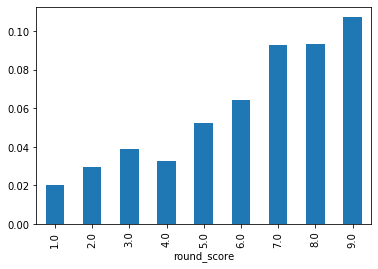

['Application Software']
2007
             Ticker  close_pct
round_score                   
4.0               1   0.046987
5.0               3   0.063092
6.0               1   0.074771


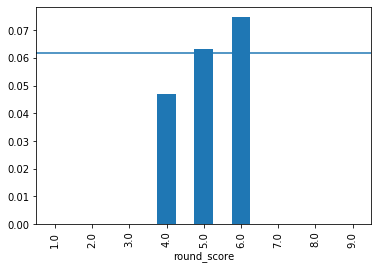

['Application Software']
2008
             Ticker  close_pct
round_score                   
5.0               2  -0.138284
6.0               3  -0.074141


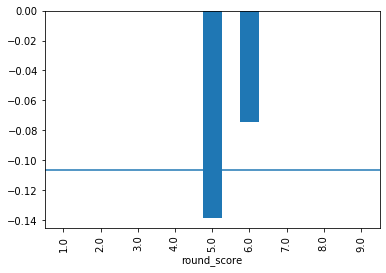

['Application Software']
2009
             Ticker  close_pct
round_score                   
4.0               3   0.066688
5.0               5   0.015226


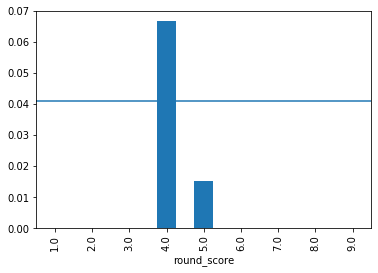

['Application Software']
2010
Empty DataFrame
Columns: [Ticker, close_pct]
Index: []


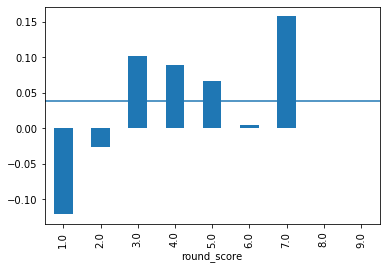

['Application Software']
2011
             Ticker  close_pct
round_score                   
1.0               3  -0.121371
2.0               2  -0.026673
3.0               7   0.102180
4.0              19   0.089001
5.0              41   0.066170
6.0              37   0.004001
7.0              11   0.157274


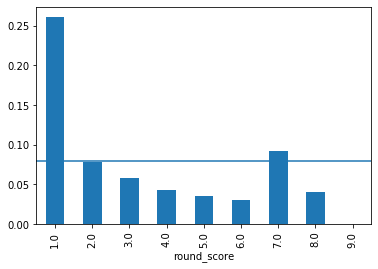

['Application Software']
2012
             Ticker  close_pct
round_score                   
1.0               2   0.260928
2.0              12   0.077973
3.0              18   0.058000
4.0              49   0.043487
5.0              75   0.034828
6.0              67   0.030727
7.0              17   0.092550
8.0               7   0.040377


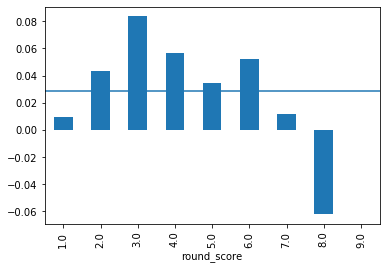

['Application Software']
2013
             Ticker  close_pct
round_score                   
1.0               3   0.009459
2.0              15   0.043491
3.0              45   0.083472
4.0              57   0.056357
5.0             115   0.034849
6.0              53   0.052454
7.0              31   0.011892
8.0               5  -0.062058


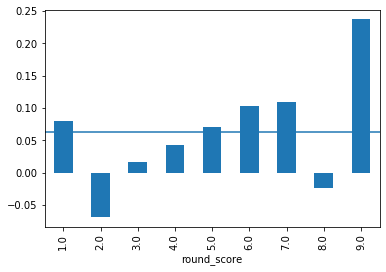

['Application Software']
2014
             Ticker  close_pct
round_score                   
1.0               4   0.080034
2.0              26  -0.068641
3.0              46   0.016855
4.0              79   0.043000
5.0             115   0.070041
6.0              73   0.103516
7.0              24   0.109081
8.0               8  -0.024201
9.0               2   0.237030


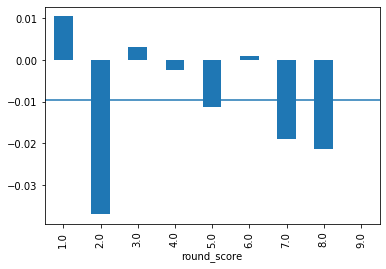

['Application Software']
2015
             Ticker  close_pct
round_score                   
1.0               6   0.010431
2.0              23  -0.037000
3.0              47   0.003210
4.0             117  -0.002393
5.0             120  -0.011365
6.0              82   0.000873
7.0              32  -0.018903
8.0              15  -0.021344


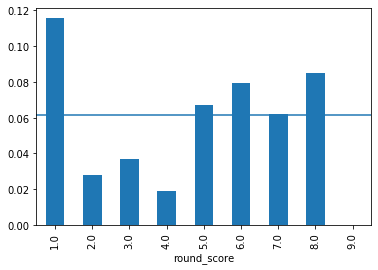

['Application Software']
2016
             Ticker  close_pct
round_score                   
1.0               3   0.115796
2.0              23   0.028026
3.0              71   0.036730
4.0             119   0.018858
5.0             121   0.067275
6.0              88   0.079448
7.0              33   0.062142
8.0              26   0.084803


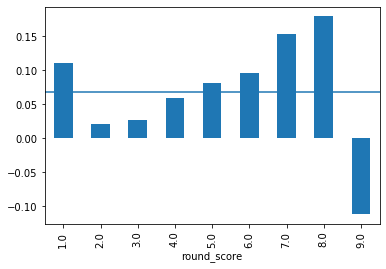

['Application Software']
2017
             Ticker  close_pct
round_score                   
1.0               2   0.110061
2.0              31   0.020348
3.0              73   0.027128
4.0             105   0.058449
5.0             128   0.080529
6.0              91   0.096544
7.0              45   0.153734
8.0              26   0.178974
9.0               1  -0.111628


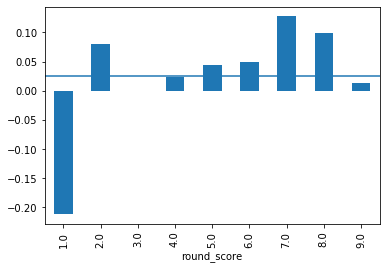

['Application Software']
2018
             Ticker  close_pct
round_score                   
1.0               5  -0.211757
2.0              15   0.080209
3.0              53  -0.000002
4.0             119   0.023486
5.0             124   0.043476
6.0              94   0.049936
7.0              69   0.127301
8.0              32   0.098671
9.0               2   0.013033


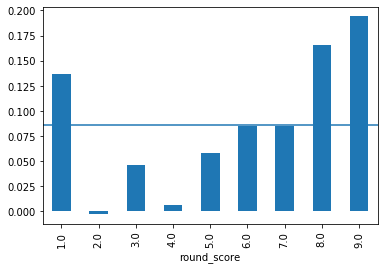

['Application Software']
2019
             Ticker  close_pct
round_score                   
1.0               3   0.136416
2.0              14  -0.002701
3.0              83   0.046037
4.0             115   0.006750
5.0             140   0.058213
6.0              88   0.085226
7.0              61   0.084596
8.0              15   0.165770
9.0               4   0.194046


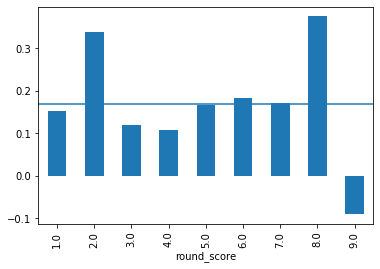

TEST DATASET RESULTS
['Application Software']


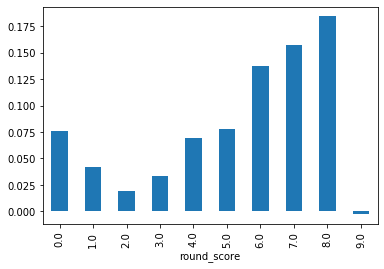

In [16]:
analyze('Application Software')

In [17]:
check_score('AAPL')

AAPL
APPLE INC
Computer Hardware
Price:  124.4
0     cfo_growth_1_score
1    cfo_margrow_1_score
2        cfo_yield_score
3    fcf_margrow_1_score
4     fcf_growth_1_score
5         ev_sales_score
6          cash_mc_score
dtype: object
Value Features: ['cfo_yield_score', 'ev_sales_score']
Quality Features: []
Growth Features: ['cfo_growth_1_score', 'fcf_growth_1_score']
Margin Growth Features: ['cfo_margrow_1_score', 'fcf_margrow_1_score']
Balance Sheet Features: ['cash_mc_score']


Value Weight:  0.2826382949914304
Growth Weight:  0.21301390198811415
Quality Weight:  nan
Margin Growth Weight:  0.19389113783851233
Balance Sheet Weight:  0.31045666518194326


Value Score: 1.5
Quality Score: nan
Growth Score: 5.0
Margin Growth Score: 5.5
Balance Sheet Score: 1.0
Total Score: 2.8658848757214774


,AAPL,AAPL,mean,std,min,25%,50%,75%
cfo_growth_1,0.137536,5.0,0.081068,37.664421,-351.320856,-0.412800,0.062311,0.391549
cfo_margrow_1,0.088182,5.0,0.530736,60.732781,-397.727495,-0.475940,0.009624,0.314092
cfo_yield,0.036266,2.0,0.052196,0.171821,-4.314383,0.029393,0.060841,0.099482
fcf_margrow_1,0.141243,6.0,0.300705,35.554734,-861.224915,-0.640616,-0.006761,0.443980
fcf_growth_1,0.187725,5.0,0.331313,33.355143,-806.154472,-0.605001,0.052577,0.486741
ev_sales,8.127835,1.0,3.408489,22.055191,-0.554132,0.571384,1.315376,2.519764
cash_mc,0.042166,1.0,0.177396,0.166483,0.000000,0.073101,0.135573,0.232622


# Set DF

Assigning testdf and traindf as a full dataframe of companies with their scores. Testdf is latest data. Traindf is everything prior.

In [18]:
testdf = fulltest(train.Industry.unique().tolist())
traindf = fulltrain(train.Industry.unique().tolist())

# Long/Short

# Long

Companies with scores greater than 8.

In [19]:
long = testdf[(testdf.round_score >=8)&(testdf.mc>1e+08)&(~testdf.ebitda_margrow_1.isnull())].\
sort_values(['score'], ascending = False )\
[['Ticker','Company Name','Industry','publish_date','score']] 

Check the distribution of industries in the with scores > 8.

In [20]:
long.Industry.value_counts()

Application Software            4
Transportation & Logistics      4
Online Media                    3
Computer Hardware               3
Retail - Defensive              3
Semiconductors                  2
Autos                           2
Industrial Distribution         2
Utilities - Regulated           1
Asset Management                1
Retail - Apparel & Specialty    1
Drug Manufacturers              1
Oil & Gas - Integrated          1
REITs                           1
Consumer Packaged Goods         1
Diversified Holdings            1
Packaging & Containers          1
Real Estate Services            1
Steel                           1
Entertainment                   1
Name: Industry, dtype: int64

Combine dataframe with score change

In [21]:
empty = []
for x in long.Ticker:
    try:
        empty.append(score_change(x))
    except:
        pass
    
scorechangelong = pd.DataFrame([long.Ticker.tolist(),empty]).transpose().sort_values(by = 1).\
rename(columns = {0:'Ticker', 1: 'scorechange'})

longwchange = pd.merge(long, scorechangelong, how = 'left',on = 'Ticker').sort_values(['scorechange'], ascending = False)

In [22]:
longwchange.sort_values(['publish_date'],ascending = False).head(10)

,Ticker,Company Name,Industry,publish_date,score,scorechange
10,MEIP,"MEI Pharma, Inc.",Drug Manufacturers,2020-09-09,8.331487,1.77867
3,BIG,BIG LOTS INC,Retail - Defensive,2020-09-09,8.808651,0.499587
14,HIBB,HIBBETT SPORTS INC,Retail - Apparel & Specialty,2020-09-04,8.037247,1.49287
13,ZM,"Zoom Video Communications, Inc.",Application Software,2020-09-03,8.129271,4.95417
28,ESTC,Elastic N.V.,Application Software,2020-09-03,7.754990,0
29,AOSL,ALPHA & OMEGA SEMICONDUCTOR Ltd,Semiconductors,2020-09-02,7.715453,0.302169
12,KE,"Kimball Electronics, Inc.",Computer Hardware,2020-08-27,8.209949,0.557811
34,AIT,APPLIED INDUSTRIAL TECHNOLOGIES INC,Industrial Distribution,2020-08-14,7.572632,0.277624
21,DXPE,DXP ENTERPRISES INC,Industrial Distribution,2020-08-10,7.929474,-0.437621
7,SMSI,SMITH MICRO SOFTWARE INC,Application Software,2020-08-10,8.620468,-0.351442


In [23]:
check_score('BIG')

BIG
BIG LOTS INC
Retail - Defensive
Price:  50.65
0       gp_growth_1_score
1           cash_mc_score
2       ni_growth_1_score
3         gp_margin_score
4         ev_ebitda_score
5      rev_growth_1_score
6     fcf_margrow_1_score
7         np_margin_score
8      np_margrow_1_score
9      fcf_growth_1_score
10        cfo_yield_score
11       fcf_margin_score
12    cfo_margrow_1_score
13    lt_invest_apr_score
14    ebitda_margin_score
15       cfo_margin_score
16     cfo_growth_1_score
17        fcf_yield_score
dtype: object
Value Features: ['ev_ebitda_score', 'cfo_yield_score', 'fcf_yield_score']
Quality Features: ['gp_margin_score', 'np_margin_score', 'fcf_margin_score', 'ebitda_margin_score', 'cfo_margin_score']
Growth Features: ['gp_growth_1_score', 'ni_growth_1_score', 'rev_growth_1_score', 'fcf_growth_1_score', 'cfo_growth_1_score']
Margin Growth Features: ['fcf_margrow_1_score', 'np_margrow_1_score', 'cfo_margrow_1_score']
Balance Sheet Features: ['cash_mc_score', 'lt_invest_ap

,BIG,BIG,mean,std,min,25%,50%,75%
gp_growth_1,0.091818,7.0,0.052386,0.118817,-1.106938,0.012195,0.051014,0.099171
cash_mc,0.450254,9.0,0.060532,0.069209,0.000182,0.013885,0.033516,0.084616
ni_growth_1,0.829360,9.0,-0.316092,3.314669,-40.842784,-0.176025,0.062719,0.269260
gp_margin,0.401434,9.0,0.259159,0.088609,0.058579,0.193497,0.270560,0.313008
ev_ebitda,1.016062,10.0,10.883845,17.473017,-217.612349,7.781628,10.278470,13.158535
rev_growth_1,0.095958,7.0,0.056502,0.116837,-0.901325,0.012500,0.046875,0.096278
fcf_margrow_1,1.021116,8.0,7.630735,206.522313,-103.289246,-0.861468,-0.022369,0.366850
np_margin,0.123251,9.0,0.026861,0.031874,-0.083186,0.012987,0.022600,0.037676
np_margrow_1,0.811248,9.0,-0.436203,3.596779,-44.986144,-0.256192,-0.000025,0.217825
fcf_growth_1,1.019090,8.0,7.592568,204.895268,-98.000000,-0.772239,0.024065,0.411481


# High Middle

Companies with scores 6 or 7.

In [24]:
highmiddle = testdf[(testdf.round_score >=6)&(testdf.round_score <=7)&(testdf.mc>1e+08)&(~testdf.ebitda_margrow_1.isnull())].\
sort_values(['score'], ascending = False )\
[['Ticker','Company Name','Industry','publish_date','score','mc']] 

In [25]:
empty = []
for x in highmiddle.Ticker:
    try:
        empty.append(score_change(x))
    except:
        pass
    
scorechangehighmiddle = pd.DataFrame([highmiddle.Ticker.tolist(),empty]).transpose().sort_values(by = 1).\
rename(columns = {0:'Ticker', 1: 'scorechange'})

highmiddlewchange = pd.merge(highmiddle, scorechangehighmiddle, how = 'left',on = 'Ticker').\
sort_values(['mc','publish_date'], ascending = False)

In [26]:
highmiddlewchange.sort_values('publish_date').head(10)

,Ticker,Company Name,Industry,publish_date,score,mc,scorechange
203,QTNA,QUANTENNA COMMUNICATIONS INC,Semiconductors,2019-04-30,5.825404,9.858167e+08,0.0400878
48,VRA,"Vera Bradley, Inc.",Manufacturing - Apparel & Furniture,2019-06-12,6.870224,2.495011e+08,1.13956
252,TYPE,Monotype Imaging Holdings Inc.,Application Software,2019-07-26,5.571221,7.992341e+08,-0.0379049
74,DATA,Tableau Software Inc,Application Software,2019-07-31,6.644920,1.438407e+10,-1.84491
238,CBLK,"Carbon Black, Inc.",Application Software,2019-08-01,5.648134,1.822069e+09,-0.431792
143,PCMI,"PCM, INC.",Computer Hardware,2019-08-08,6.143757,4.529856e+08,0.586137
188,SYRG,SRC Energy Inc.,Oil & Gas - E&P,2019-11-06,5.896097,9.736617e+08,0.520719
67,WAIR,"Wesco Aircraft Holdings, Inc",Industrial Distribution,2019-11-26,6.713684,1.106640e+09,0.0991174
133,COUP,Coupa Software Inc,Application Software,2019-12-03,6.199098,1.885387e+10,1.0531
176,EPD,ENTERPRISE PRODUCTS PARTNERS L P,Oil & Gas - Midstream,2020-05-08,5.955117,3.817496e+10,0.0585779


In [27]:
highmiddle.Industry.value_counts()

Application Software                   35
Retail - Apparel & Specialty           19
Industrial Products                    17
Computer Hardware                      14
Semiconductors                         10
Autos                                   9
Communication Services                  8
Medical Diagnostics & Research          7
Manufacturing - Apparel & Furniture     6
Restaurants                             6
Oil & Gas - E&P                         6
Business Services                       6
Retail - Defensive                      6
Building Materials                      6
REITs                                   6
Chemicals                               5
Farm & Construction Machinery           5
Brokers & Exchanges                     5
Steel                                   5
Oil & Gas - Midstream                   5
Utilities - Regulated                   4
Industrial Distribution                 4
Communication Equipment                 4
Asset Management                  

# Short

Companies with scores less than or equal to 2.

In [28]:
short = testdf[(testdf.round_score <=2)&(testdf.mc>1e+08)&(~testdf.ebitda_margrow_1.isnull())].\
sort_values(['publish_date','score'], ascending = False )\
[['Ticker','Company Name','Industry','publish_date','score']] 

In [29]:
empty = []
for x in short.Ticker:
    try:
        empty.append(score_change(x))
    except:
        pass
    
scorechangeshort = pd.DataFrame([short.Ticker.tolist(),empty]).transpose().sort_values(by = 1).\
rename(columns = {0:'Ticker', 1: 'scorechange'})

shortwchange = pd.merge(short, scorechangeshort, how = 'left',on = 'Ticker').\
sort_values(['scorechange'], ascending = False)

In [30]:
shortwchange.sort_values('publish_date').head(10)

,Ticker,Company Name,Industry,publish_date,score,scorechange
158,CHSP,Chesapeake Lodging Trust,REITs,2019-08-01,1.561711,None
157,VSM,"Versum Materials, Inc.",Chemicals,2019-08-06,1.819977,None
156,GCI,"Gannett Co., Inc.",Publishing,2019-11-05,1.731780,None
155,VFC,V F CORP,Manufacturing - Apparel & Furniture,2020-02-04,1.159658,-0.323973
154,HCHC,"HC2 HOLDINGS, INC.",Communication Services,2020-03-16,2.455344,-3.0858
153,CDE,"Coeur Mining, Inc.",Metals & Mining,2020-04-22,1.807678,0.0251894
150,KIM,Kimco Realty,REITs,2020-05-08,1.687790,-0.246507
151,MVIS,"MICROVISION, INC.",Computer Hardware,2020-05-08,1.381157,-2.63644
152,WTR,Aqua America Inc,Utilities - Regulated,2020-05-08,0.307592,-0.462121
149,CZR,CAESARS ENTERTAINMENT Corp,Travel & Leisure,2020-05-11,2.050563,-2.76021


In [31]:
check_score('BRKS')

BRKS
BROOKS AUTOMATION INC
Semiconductors
Price:  52.82
0     fcf_margrow_1_score
1    acq_divest_apr_score
2          ev_sales_score
3           cash_mc_score
4               fat_score
5      fcf_growth_1_score
dtype: object
Value Features: ['ev_sales_score']
Quality Features: ['fat_score']
Growth Features: ['fcf_growth_1_score']
Margin Growth Features: ['fcf_margrow_1_score']
Balance Sheet Features: ['acq_divest_apr_score', 'cash_mc_score']


Value Weight:  0.19963968229260798
Growth Weight:  0.21733892291515985
Quality Weight:  0.21726239731836539
Margin Growth Weight:  0.1675241752672304
Balance Sheet Weight:  0.19823482220663624


Value Score: 3.0
Quality Score: 3.0
Growth Score: 0.0
Margin Growth Score: 0.0
Balance Sheet Score: 1.0
Total Score: 1.4489410610395566


,BRKS,BRKS,mean,std,min,25%,50%,75%
fcf_margrow_1,-5.597893,0.0,0.027618,9.829952,-124.690246,-0.432259,0.030259,0.423396
acq_divest_apr,NaN,NaN,0.146591,0.381014,-2.253693,0.000766,0.016065,0.165091
ev_sales,4.321737,3.0,3.238615,2.759481,-0.940300,1.246379,2.490223,4.423671
cash_mc,0.066159,1.0,0.225819,0.189683,0.014387,0.099946,0.176442,0.305652
fat,0.569569,3.0,0.751059,0.387705,0.060303,0.498655,0.689036,0.914853
fcf_growth_1,-4.460012,0.0,0.017025,9.972889,-122.107143,-0.377036,0.064505,0.457765


# Low Middle

Companies with scores 3,4,5.

In [32]:
lowmiddle = testdf[(testdf.round_score >=3)&(testdf.round_score <=5)&(testdf.mc>1e+08)&(~testdf.ebitda_margrow_1.isnull())].\
sort_values(['score'], ascending = False )\
[['Ticker','Company Name','Industry','publish_date','score']] 

In [33]:
empty = []
for x in lowmiddle.Ticker:
    try:
        empty.append(score_change(x))
    except:
        pass
    
scorechangelowmiddle = pd.DataFrame([lowmiddle.Ticker.tolist(),empty]).transpose().sort_values(by = 1).\
rename(columns = {0:'Ticker', 1: 'scorechange'})

lowmiddlewchange = pd.merge(lowmiddle, scorechangelowmiddle, how = 'left',on = 'Ticker').\
sort_values(['scorechange'], ascending = False)

In [34]:
lowmiddlewchange.sort_values('publish_date').head(10)

,Ticker,Company Name,Industry,publish_date,score,scorechange
8,ESL,ESTERLINE TECHNOLOGIES CORP,Aerospace & Defense,2019-02-05,5.466060,-0.160684
601,SXC,"SunCoke Energy Partners, L.P.",Coal,2019-04-24,3.471903,-0.140664
227,BMS,BEMIS CO INC,Packaging & Containers,2019-04-26,4.670471,0.0459526
638,MXWL,MAXWELL TECHNOLOGIES INC,Computer Hardware,2019-05-01,3.314019,-0.0875119
778,AYR,Aircastle LTD,Consulting & Outsourcing,2019-05-02,2.695445,0.160943
143,BRSS,"GLOBAL BRASS & COPPER HOLDINGS, INC.",Industrial Products,2019-05-02,4.926294,-0.681898
201,SFS,"Smart & Final Stores, Inc.",Retail - Defensive,2019-05-03,4.771997,2.70288
173,TVPT,Travelport Worldwide LTD,Travel & Leisure,2019-05-10,4.850073,0.0573763
655,BKS,BARNES & NOBLE INC,Retail - Apparel & Specialty,2019-06-19,3.255243,-0.807415
90,TOWR,"Tower International, Inc.",Autos,2019-07-25,5.093016,1.04976


In [35]:
lowmiddle.Industry.value_counts()

Application Software                       86
Computer Hardware                          40
Retail - Apparel & Specialty               38
Industrial Products                        37
Consumer Packaged Goods                    34
Semiconductors                             28
Business Services                          28
Medical Devices                            26
Chemicals                                  26
REITs                                      22
Autos                                      22
Medical Diagnostics & Research             22
Travel & Leisure                           21
Utilities - Regulated                      21
Aerospace & Defense                        20
Restaurants                                19
Online Media                               18
Manufacturing - Apparel & Furniture        17
Communication Equipment                    16
Medical Instruments & Equipment            14
Communication Services                     14
Brokers & Exchanges               

# End DF

### Companies trading at their 52wk low

In [36]:
daily = sf.asfreq(df = df_prices, freq = 'D', method = 'ffill').reset_index()
start_date = datetime.now() - timedelta(weeks = 104)
end_date = datetime.now()

mask = (daily.Date > start_date) & (daily.Date <= end_date)
maskdf = daily.loc[mask]

high = pd.DataFrame(maskdf.groupby('Ticker').Close.max()).rename(columns = {'Close':'52wkhigh'})
low = pd.DataFrame(maskdf.groupby('Ticker').Close.min()).rename(columns = {'Close':'52wklow'})
highlow = pd.merge(high, low, on = 'Ticker')

prices = pd.merge(maskdf, highlow, on = 'Ticker')
prices['highdiff'] = prices.Close/prices['52wkhigh']
prices['lowdiff'] = prices.Close/prices['52wklow']

In [37]:
latest_date = prices.Date.max()
percentage_change = 0.65
low = prices[(prices.Date == latest_date)&(prices.highdiff < percentage_change)].Ticker.unique()

In [38]:
testdf[testdf.Ticker.isin(low)].sort_values('ev_sales', ascending = 'False').head(10)

,Ticker,Company Name,Report Date,publish_date,year,quarter,Sector,Industry,mc,ev,ev_sales,ev_ebitda,ebitda_margin,cf_invest_apr,lt_invest_apr,acq_divest_apr,gp_margin,np_margin,cfo_margin,fcf_margin,fat,cash_mc,fcf_yield,cfo_yield,bs_debt_ebitda,bs_ppe_apev,bs_current_ratio,rev_growth_1,gp_growth_1,oi_growth_1,ni_growth_1,ebitda_growth_1,cfo_growth_1,fcf_growth_1,ebitda_margrow_1,gp_margrow_1,np_margrow_1,cfo_margrow_1,fcf_margrow_1,close_pct,ev_sales_score,ev_ebitda_score,bs_debt_ebitda_score,ebitda_margin_score,gp_margin_score,np_margin_score,cfo_margin_score,fcf_margin_score,fat_score,cash_mc_score,fcf_yield_score,cfo_yield_score,bs_ppe_apev_score,bs_current_ratio_score,cf_invest_apr_score,lt_invest_apr_score,acq_divest_apr_score,rev_growth_1_score,gp_growth_1_score,oi_growth_1_score,ni_growth_1_score,ebitda_growth_1_score,cfo_growth_1_score,fcf_growth_1_score,ebitda_margrow_1_score,gp_margrow_1_score,np_margrow_1_score,cfo_margrow_1_score,fcf_margrow_1_score,value_score,quality_score,growth_score,margrow_score,bs_score,round_value_score,round_quality_score,round_growth_score,round_margrow_score,round_bs_score,score,round_score
1209,AKER,"Akers Biosciences, Inc.",2020-06-30,2020-08-14,2020,Q2,Healthcare,Medical Instruments & Equipment,5.132767e+06,-1.317076e+07,-15.278873,1.442982,-10.588404,3.365788,3.373038,NaN,-0.371801,-10.838523,-6.202881,-6.202881,0.145321,3.566015,-1.041745,-1.041745,0.000000,-1.390073,6.829534,-1.219347,-2.589293,-0.124535,-0.075952,-0.108431,0.180062,0.185769,-0.598274,-1.716109,-0.583640,-0.468284,-0.465712,-0.150735,10.0,8.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,8,9.0,9.0,NaN,0.0,0.0,2.0,3.0,2.0,6.0,6.0,0.0,0.0,1.0,1.0,1.0,0.000000,0.000000,2.166667,0.5,9.000000,0.0,0.0,2.0,0.0,9.0,2.740884,3.0
1270,AMDA,AMEDICA Corp,2020-06-30,2020-08-12,2020,Q2,Healthcare,Medical Devices,1.199026e+07,-5.713745e+06,-6.834623,0.900015,-7.593900,-1.875598,NaN,NaN,0.200957,-6.336124,-10.040670,-10.290670,0.074133,1.511644,-0.717499,-0.700068,NaN,-3.170600,10.618441,5.750000,20.011905,-0.160446,0.000566,-0.035205,-0.228377,-0.256538,-1.203115,-3.002506,-1.210646,-1.162447,-1.156518,0.175758,10.0,8.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,9,0.0,NaN,NaN,9.0,9.0,2.0,4.0,3.0,2.0,2.0,0.0,0.0,1.0,0.0,1.0,2.666667,0.000000,7.000000,0.0,4.500000,3.0,0.0,7.0,0.0,4.0,2.473647,2.0
1481,MARK,"REMARK HOLDINGS, INC.",2020-06-30,2020-08-14,2020,Q2,Technology,Online Media,7.383394e+07,6.602594e+07,-4.529149,-3.072975,1.473865,-0.001029,NaN,NaN,0.920085,1.799081,0.986418,0.986418,-0.572787,0.138595,-0.194761,-0.194761,NaN,0.150910,0.797709,-5.390246,-4.252591,0.297486,-0.141724,-0.084474,0.155355,0.088248,1.208536,0.259132,1.195496,1.263164,1.247879,0.087719,10.0,0.0,NaN,9.0,8.0,9.0,9.0,9.0,0.0,4.0,0.0,0.0,4.0,0,1.0,NaN,NaN,0.0,0.0,6.0,3.0,2.0,5.0,4.0,8.0,9.0,8.0,9.0,9.0,0.000000,NaN,NaN,NaN,2.000000,0.0,NaN,NaN,NaN,2.0,0.700104,1.0
1362,NSPR,"InspireMD, Inc.",2020-06-30,2020-08-05,2020,Q2,Healthcare,Medical Devices,1.933955e+06,-1.192705e+07,-3.615352,1.347004,-2.683995,0.059715,NaN,NaN,0.170355,-2.753865,-2.202182,-2.238254,0.355343,7.167179,-3.818083,-3.756551,0.000000,-1.200633,4.884888,-0.018490,-0.412811,0.058863,0.060759,0.064035,0.378390,0.383803,0.044718,-0.387162,0.041502,0.353365,0.358680,-0.250000,10.0,7.0,10.0,0.0,0.0,0.0,0.0,0.0,1.0,9.0,0.0,0.0,0.0,7,4.0,NaN,NaN,1.0,0.0,4.0,4.0,4.0,7.0,7.0,5.0,0.0,4.0,7.0,7.0,2.333333,0.166667,1.666667,0.0,5.500000,2.0,0.0,2.0,0.0,6.0,1.983941,2.0
1274,HCHC,"HC2 HOLDINGS, INC.",2019-12-31,2020-03-16,2019,Q4,Business Services,Communication Services,1.084160e+08,-3.412684e+09,-1.720016,-32.610454,0.052744,0.132907,0.472053,0.030593,0.281841,-0.015876,0.055693,0.037145,0.305068,40.219156,0.679789,1.019222,8.020067,-1.150678,1.132400,0.003730,0.299893,1.663496,-6.142857,-0.250358,-2.089593,-3.173677,-0.255039,0.297272,-6.162110,-2.101159,-3.189302,0.635135,10.0,0.0,2.0,1.0,0.0,2.0,1.0,3.0,2.0,9.0,9.0,9.0,0.0,5,3.0,9.0,5.0,3.0,9.0,9.0,0.0,1.0,0.0,0.0,1.0,9.0,0.0,0.0,0.0,NaN,1.00